In [1]:
#importing the packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import date,timedelta,datetime
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegressionCV
import glob
pd.set_option('mode.chained_assignment', None)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
#function to get week end date from date
def week_end_end(n):
    year, month, day = (int(x) for x in n.split('-'))  
    #d is the given date
    d =  date(year, month, day)
    #0-monday 6-sunday
    w = d.weekday()
    #print(w)
    if w<5:
        week_end = d + timedelta(5-w)
        week_start = d - timedelta(w+1)
    elif w == 5:
        week_end = d
        week_start = d - timedelta(w+1)
    else:
        week_end = d + timedelta(6)
        week_start = d
    return week_end.strftime('%Y-%m-%d')

In [3]:
#function to get prices of products
def similar_product_price(prd,prds):
    prd_price = price.loc[price.p_id.isin(prds)][["UT_ID","WK_END_DT","p_id","Final_Price"]]
    prd_price_pivot = prd_price.pivot(index=["UT_ID","WK_END_DT"], columns="p_id", values="Final_Price").rename_axis(None, axis=1).reset_index()
    renamed_cols = ["price_"+str(i) for i in prd_price_pivot.columns.tolist() if i not in ["UT_ID","WK_END_DT"]]
    renamed_cols[renamed_cols.index("price_"+str(prd))] = "price"
    prd_price_pivot.columns = ["UT_ID","WK_END_DT"] + renamed_cols
    prd_price_pivot.columns = ["UT_ID","WK_END_DT","price"] + [i for i in prd_price_pivot.columns if "price_" in i]
    for col in prd_price_pivot.columns[2:].tolist():
        prd_price_pivot[col] = prd_price_pivot[col].fillna(prd_price_pivot[col].max())
        prd_price_pivot.loc[prd_price_pivot[col]<=0,col] = prd_price_pivot[col].max()
        prd_price_pivot[col] = np.log(prd_price_pivot[col])
    return prd_price_pivot

In [4]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def add_current_features_feature():

    week_dt = datetime.strptime(week, '%Y-%m-%d')

    df = transactions_prior_weeks.copy()
    df['DAY_DT'] = pd.to_datetime(df['DAY_DT']) #changing DAY_DT column to datetime for fltering and comparison
 
    #creating dataframe containing transaction info based on the lag week time windows
    df ['freq_category'] = 'freq'
    df.loc[((df['DAY_DT'] > (week_dt- timedelta(  5*7))) & (df['DAY_DT'] <= (week_dt- timedelta(   7)))), ['freq_category']]  = 'freq_0_to_3_week'   
    df.loc[((df['DAY_DT'] > (week_dt- timedelta( 23*7))) & (df['DAY_DT'] <= (week_dt- timedelta( 5*7)))), ['freq_category']]  = 'freq_4_to_22_week'  
    df.loc[((df['DAY_DT'] > (week_dt- timedelta( 34*7))) & (df['DAY_DT'] <= (week_dt- timedelta(23*7)))), ['freq_category']]  = 'freq_23_to_33_week' 
    df.loc[((df['DAY_DT'] > (week_dt- timedelta( 56*7))) & (df['DAY_DT'] <= (week_dt- timedelta(34*7)))), ['freq_category']]  = 'freq_34_to_55_week' 
    df.loc[((df['DAY_DT'] > (week_dt- timedelta(110*7))) & (df['DAY_DT'] <= (week_dt- timedelta(56*7)))), ['freq_category']]  = 'freq_56_to_110_week'
    #df.loc[                                               (df['DAY_DT'] <= (week_dt- timedelta(110*7))) , ['freq_category']] ='freq_above_110_week'
    #df ['price_category'] = df['freq_category'].str.replace('freq','avg_spend')
    
    df_date = df.groupby(['MPERK_PGM_ENRL_ID']).agg({'DAY_DT':'max'}).rename(columns={'DAY_DT':'latest_date'}).reset_index()
    df_quantity = df.groupby(['MPERK_PGM_ENRL_ID']).agg({'quantity_sold':'max'}).rename(columns={'quantity_sold':'quantity_sold'}).reset_index()
    df_quantity['more_than_1_sold_single_trip']= np.where(df_quantity["quantity_sold"   ]>1, 1,0)
    
    df = df.groupby(['MPERK_PGM_ENRL_ID','freq_category']).agg({'MPERK_PGM_ENRL_ID':'size'}).rename(columns={'MPERK_PGM_ENRL_ID':'count'}).reset_index()
    df = pd.pivot_table(df, values = 'count', index=['MPERK_PGM_ENRL_ID'], columns = 'freq_category').fillna(0).reset_index()
    #df_price = pd.pivot_table(df, values = 'avg_spent', index=['MPERK_PGM_ENRL_ID'], columns = 'price_category').fillna(0).reset_index()

    #df = pd.merge(df_freq,df_price,  on = 'MPERK_PGM_ENRL_ID', how = 'inner').fillna(0)
    #del df_freq,df_price
    
    
    if 'freq_0_to_3_week' not in df:
        df['freq_0_to_3_week'] = 0
        df['recency_0_to_3_week'] = 0
    else :
        df['recency_0_to_3_week'   ] = np.where(df["freq_0_to_3_week"   ]>0, 1,0)
    
    if 'freq_4_to_22_week' not in df:
        df['freq_4_to_22_week'] = 0
        df['recency_4_to_22_week'] = 0
    else :
        df['recency_4_to_22_week'   ] = np.where(df["freq_4_to_22_week"   ]>0, 1,0)
    
    if 'freq_23_to_33_week' not in df:
        df['freq_23_to_33_week'] = 0
        df['recency_23_to_33_week'] = 0
    else :
        df['recency_23_to_33_week'   ] = np.where(df["freq_23_to_33_week"   ]>0, 1,0)
    
    if 'freq_34_to_55_week' not in df:
        df['freq_34_to_55_week'] = 0
        df['recency_34_to_55_week'] = 0
    else :
        df['recency_34_to_55_week'   ] = np.where(df["freq_34_to_55_week"   ]>0, 1,0)
    
    if 'freq_56_to_110_week' not in df:
        df['freq_56_to_110_week'] = 0
        df['recency_56_to_110_week'] = 0
    else :
        df['recency_56_to_110_week'   ] = np.where(df["freq_56_to_110_week"   ]>0, 1,0)
    
    df['total_trips'] = df['freq_0_to_3_week'] + df['freq_4_to_22_week'] + df['freq_23_to_33_week'] + df['freq_34_to_55_week'] + df['freq_56_to_110_week'] 
    
    df = pd.merge(df,df_date,  on = 'MPERK_PGM_ENRL_ID', how = 'inner').fillna(0)
    df = pd.merge(df,df_quantity,  on = 'MPERK_PGM_ENRL_ID', how = 'inner').fillna(0)
    
    df['days_since_last_purchase'] =  (week_dt  - df['latest_date'] ).dt.days
    
    unwanted = df.columns[df.columns.str.startswith('freq')]
    df.drop(unwanted, axis=1, inplace=True)
    df.drop('latest_date', axis=1, inplace=True)
    return df

In [6]:
#reading other files
products = pd.read_csv(r"/depot/lanhamm/project-meijer2/Other/Meijer_P_ID.txt", sep="\t")
ut_id = pd.read_csv(r"/depot/lanhamm/project-meijer2/Other/Meijer_UT_ID.txt", sep="\t")
basket_affinity = pd.read_csv(r"/depot/lanhamm/project-meijer2/Other/Meijer_Basket_Affinity.01.31.txt", sep="\t")

In [7]:
#choosing L3 - Meijer Merchandise Area Description for analysis
L_3 = "READY TO EAT CEREAL" #L_6 = "FRESH" "GROCERY" 
products_l3 = products.loc[products["MJR_P_SUB_CT_NM_TX"]==L_3]["P_ID"].tolist()

In [8]:
# #reading the transaction files - run only if you want to create a different subset of transaction dataset
# files = glob.glob("/depot/lanhamm/project-meijer2/transaction/Meijer_Transaction*.txt")
# transactions = pd.DataFrame()
# for i,f in enumerate(files):
#     transaction = pd.read_csv(f ,  sep="\t", parse_dates=["DAY_DT"])
#     print("file"+str(i+1)+" read", end=" ")
#     transaction = transaction.loc[transaction["p_id"].isin(products_l3)]
#     transactions = transactions.append(transaction)
#     print("and processed")
# transactions.to_csv("/scratch/gilbreth/jain475/Transactions_rte_cereal.csv", index=False)

In [9]:
#reading the subset transaction file
transactions = pd.read_csv("/depot/lanhamm/project-meijer2/Transaction subset/Transactions_rte_cereal.csv" , parse_dates=["DAY_DT"])

In [10]:
# #reading the price files - run only if you want to create a different subset of price dataset
# files = glob.glob("/depot/lanhamm/project-meijer2/Pricing_Full_Data/Meijer_Price*.txt")
# price = pd.DataFrame()
# for i,f in enumerate(files):
#     prc = pd.read_csv(f ,  sep=" ", parse_dates=["WK_END_DT"])
#     print("file"+str(i+1)+" read", end=" ")
#     prc = prc.loc[prc["p_id"].isin(products_l3)]
#     price = price.append(prc)
#     print("and processed")
# #price.to_csv("/scratch/gilbreth/jain475/Price_rte_cereal.csv", index=False)

In [11]:
#reading the subset price file
price = pd.read_csv("/depot/lanhamm/project-meijer2/Price subset/Price_rte_cereal.csv" , parse_dates=["WK_END_DT"])

In [12]:
#reading the substitutions file
substitution = pd.read_csv("/home/srinival/depot/lanhamm/project-meijer2/Substitution/Meijer_Substitute_Accept.txt", sep="\t", parse_dates=["DAY_DT"])

In [13]:
#formatting the date columns to str - this takes some time
transactions['DAY_DT'] = transactions['DAY_DT'].dt.strftime('%Y-%m-%d')
price['WK_END_DT'] = price['WK_END_DT'].dt.strftime('%Y-%m-%d')
#substitutions["DAY_DT"] = substitutions['DAY_DT'].dt.strftime('%Y-%m-%d')

In [14]:
#checking the file size
print(transactions.shape)
print(price.shape)
#print(substitutions.shape)
print(products.shape)
print(ut_id.shape)
print(basket_affinity.shape)

(5735495, 16)
(3072767, 11)
(387859, 13)
(262, 32)
(991512, 23)


In [15]:
transactions.head(1)

,UT_ID,DAY_DT,minute_of_day,TN_ID,SHOP_CHNL_CT,MPERK_PGM_ENRL_ID,p_id,Purchased_at_Regular_Price,Purchased_on_Sale,Received_Additional_Discounts,Regular_Price,Price_Reduction_Amount,Additional_discount_amount,Final_Price,weight_sold,quantity_sold
0,189,2020-07-22,885,6181200805,0,46800020096,490010,1,0,0,3.99,0.0,0.0,3.99,0.0,1


In [16]:
price.head(1)

,UT_ID,WK_END_DT,p_id,unit,Price_Reduction_Sale,additional_discount_available,Regular_Price,Price_Reduction_Amount,Shelf_Price,additional_discount,Final_Price
0,7,2020-10-03,476926,EA,0,1,0.01,-1.04,1.05,0.04,1.01


In [17]:
products.head(1)

,MJR_MDS_ARE_ID,MJR_MDS_ARE_NM_TX,MJR_BUS_SEG_ID,MJR_BUS_SEG_NM_TX,MJR_P_CT_ID,MJR_P_CT_NM_TX,MJR_P_SUB_CT_ID,MJR_P_SUB_CT_NM_TX,MJR_P_CLS_ID,MJR_P_CLS_NM_TX,P_BRND_CT_ID,P_ID,P_NM
0,L6-000005,GROCERY,L5-000059,DRY GROCERY,L4-000624,CEREAL PANCAKE AND OATMEAL,L3-002673,READY TO EAT CEREAL,L2-011019,ADULT RTE CEREAL,POST,4084029,POST GREAT GRAINS BLUEBERRY 13.5 OZ


In [18]:
#adding week end date in transactions table
transactions["WK_END_DT"] = transactions.DAY_DT.apply(week_end_end)
print(transactions.shape)

#joining the transactions table with product table
transactions = transactions.merge(products[["P_ID","P_BRND_CT_ID","MJR_P_SUB_CT_NM_TX","P_NM"]], left_on="p_id", right_on="P_ID", how="left")
print(transactions.shape)

#joining the transactions table with price table
transactions = transactions.merge(price[["WK_END_DT","p_id","UT_ID","Regular_Price","Shelf_Price","Final_Price"]], on=["WK_END_DT","p_id","UT_ID"], how="left")
print(transactions.shape)

(5735495, 17)
(5735495, 21)
(5735495, 24)


In [19]:
#choosing the week and products for the creation of target dataset
weeks = sorted(transactions.WK_END_DT.unique().tolist(), reverse=True)
weeks = weeks[0:2]

products_model = products.loc[products["MJR_P_SUB_CT_NM_TX"]==L_3]["P_ID"].tolist()
products_model = transactions.loc[transactions.p_id.isin(products_model)].groupby('p_id').size().reset_index().sort_values(0,ascending=False).p_id.tolist()
products_model = products_model[0:10]

In [20]:
substitution['accepted'] = substitution['accepted'].apply(lambda x: np.where(str(x).isdigit(),x,'0')).astype(int)
substitution['rejected'] = substitution['rejected'].apply(lambda x: np.where(str(x).isdigit(),x,'0')).astype(int)

In [21]:
#Creating final dataset with features at customer, product and week level

target_dataset_all = pd.DataFrame()
for j,week in enumerate(weeks):
    print("Week",j+1)
    df1 = substitution.loc[substitution['DAY_DT']<= week] 
    df2 = substitution.loc[substitution['DAY_DT']<= week] 
    for i,prd in enumerate(products_model):
        print("Product",i+1)
        transactions_lastweek = transactions.loc[(transactions.WK_END_DT==week)]
        transactions_prior_weeks = transactions.loc[(transactions.WK_END_DT<week) & (transactions.p_id==prd)]
        customers_shopped_prior_weeks = pd.DataFrame(transactions_prior_weeks.MPERK_PGM_ENRL_ID.unique().tolist(), columns=["MPERK_PGM_ENRL_ID"])
        transactions_lastweek["bought_product"] = np.where(transactions_lastweek["p_id"]==prd, 1,0)
        cust_bought = transactions_lastweek.loc[transactions_lastweek.bought_product==1].MPERK_PGM_ENRL_ID.unique().tolist()
        if len(cust_bought) == 0:
            print("Product",i+1,"skipped")
            continue

        transactions_lastweek_notbought = transactions_lastweek.loc[~transactions_lastweek.MPERK_PGM_ENRL_ID.isin(cust_bought)]
        transactions_lastweek_notbought = transactions_lastweek_notbought.sort_values(["MPERK_PGM_ENRL_ID","TN_ID"], 
                                                                                                ascending=True).\
                                                            drop_duplicates(subset=['MPERK_PGM_ENRL_ID'], keep='last')
        transactions_lastweek_bought = transactions_lastweek.loc[(transactions_lastweek.MPERK_PGM_ENRL_ID.isin(cust_bought))
                                                                          & (transactions_lastweek.bought_product==1)]
        transactions_lastweek_bought = transactions_lastweek_bought.sort_values(["MPERK_PGM_ENRL_ID","TN_ID"], ascending=True).\
                                                            drop_duplicates(subset=['MPERK_PGM_ENRL_ID'], keep='last')
        transactions_lastweek_unique = pd.concat([transactions_lastweek_notbought,transactions_lastweek_bought], 
                                                        ignore_index=True)
        target_dataset = transactions_lastweek_unique.groupby(["MPERK_PGM_ENRL_ID","UT_ID","WK_END_DT","DAY_DT"]).agg({"bought_product":"sum"}).reset_index()
        target_dataset["bought_product"] =  np.where(target_dataset["bought_product"] >=1, 1,0)
        target_dataset = target_dataset.merge(customers_shopped_prior_weeks)
        rfm = add_current_features_feature()
        target_dataset = target_dataset.merge(rfm, on="MPERK_PGM_ENRL_ID", how="left")
        df1 = df1[df1['ordered_p_id']== prd]
        df2 = df2[df2['substitute_p_id']== prd]
        info = df1.groupby(df1['MPERK_PGM_ENRL_ID']).agg({'out_of_stock': np.sum,'substitute_attempted': np.sum,'accepted':np.sum}).reset_index()
        info1 = info[info['out_of_stock']!= 0]
        target_dataset = pd.merge(target_dataset,info1[['MPERK_PGM_ENRL_ID','accepted']], on='MPERK_PGM_ENRL_ID', how='left')
        target_dataset.rename(columns={'accepted':'sub_accepted'},inplace = True)
        info_1 = df2.groupby(df2['MPERK_PGM_ENRL_ID']).agg({'out_of_stock': np.sum,'substitute_attempted': np.sum,'accepted':np.sum}).reset_index()
        info2 = info_1[info_1['substitute_attempted']!= 0]
        target_dataset = pd.merge(target_dataset, info2[['accepted','MPERK_PGM_ENRL_ID']], on='MPERK_PGM_ENRL_ID', how='left')

        #identifying similar products
        similar_prds = products_model

        #get the prices of product and similar products
        product_prices = similar_product_price(prd,similar_prds)

        #join with target dataset
        target_dataset = target_dataset.merge(product_prices, on=["UT_ID","WK_END_DT"], how="inner")
        target_dataset_all = target_dataset_all.append(target_dataset,ignore_index=True)
        
print("Done!")

Week 1
Product 1
Product 2
Product 3
Product 4
Product 5
Product 6
Product 7
Product 8
Product 9
Product 10
Week 2
Product 1
Product 2
Product 3
Product 4
Product 5
Product 6
Product 7
Product 8
Product 9
Product 10
Done!


In [22]:
#handling null values
nas = target_dataset_all.isna().sum()
na_cols = nas[nas>0].index.tolist()
for i in na_cols:
        target_dataset_all[i] = target_dataset_all[i].fillna(target_dataset_all[i].max())

#Filtering only customer with more than 1 trips
target_dataset_all = target_dataset_all.loc[target_dataset_all.total_trips>1]
    


In [23]:
print("Step 2: Creating dataset for training")
#creating X and y datasets
y = target_dataset_all["bought_product"]
X = target_dataset_all.drop(["MPERK_PGM_ENRL_ID","UT_ID","WK_END_DT","bought_product","DAY_DT",'quantity_sold'], axis=1)

Step 2: Creating dataset for training


In [24]:
target_dataset_all.columns

Index(['MPERK_PGM_ENRL_ID', 'UT_ID', 'WK_END_DT', 'DAY_DT', 'bought_product',
       'recency_0_to_3_week', 'recency_4_to_22_week', 'recency_23_to_33_week',
       'recency_34_to_55_week', 'recency_56_to_110_week', 'total_trips',
       'quantity_sold', 'more_than_1_sold_single_trip',
       'days_since_last_purchase', 'sub_accepted', 'accepted', 'price',
       'price_473121', 'price_473391', 'price_484709', 'price_485543',
       'price_485716', 'price_489561', 'price_490010', 'price_490666',
       'price_494263', 'price_485801'],
      dtype='object')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (52600, 21)
Number transactions y_train dataset:  (52600,)
Number transactions X_test dataset:  (22544, 21)
Number transactions y_test dataset:  (22544,)


In [26]:
#scaling the values of features
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train = pd.DataFrame(scalar.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scalar.transform(X_test), columns=X_test.columns)

In [27]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 5093
Before OverSampling, counts of label '0': 47507 

After OverSampling, the shape of train_X: (95014, 21)
After OverSampling, the shape of train_y: (95014,) 

After OverSampling, counts of label '1': 47507
After OverSampling, counts of label '0': 47507


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=5)

In [29]:
lr1 = LogisticRegression(C=clf.best_params_['C'],penalty='l1', solver='liblinear', verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

LogisticRegression(penalty='l1', solver='liblinear', verbose=5)

In [30]:
# y_train_pre = lr1.predict(X_train)

# cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

# print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
# #print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])))


# class_names = [0,1]
# plt.figure()
# plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
# plt.show()


Recall metric in the train dataset: 63.085440040415094%


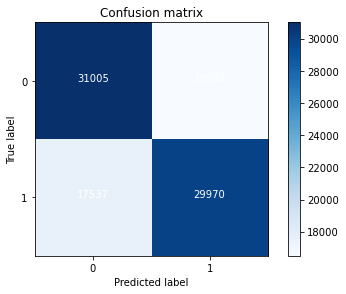

In [31]:
y_train_pre = lr1.predict(X_train_res)

cnf_matrix_tra = confusion_matrix(y_train_res, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()


Recall metric in the testing dataset: 62.1380846325167%


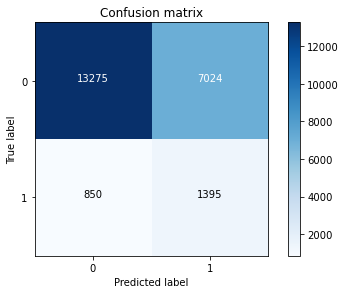

In [32]:
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

[LibLinear]

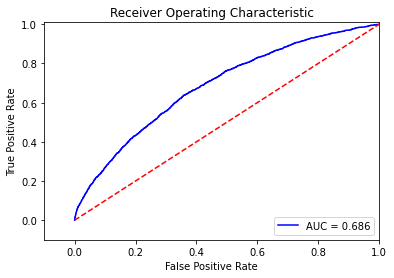

In [33]:
tmp = lr1.fit(X_train_res, y_train_res.ravel())

y_pred_sample_score = tmp.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
coeff = pd.DataFrame()
coeff["variable"] = X_train.columns.tolist()
coeff["coeff"] = np.exp(lr1.coef_[0].tolist())
coeff.sort_values("coeff", ascending=False)

,variable,coeff
5,total_trips,1.266907
0,recency_0_to_3_week,1.163997
1,recency_4_to_22_week,1.125696
12,price_473391,1.103409
16,price_489561,1.083741
19,price_494263,1.069255
6,more_than_1_sold_single_trip,1.036519
2,recency_23_to_33_week,1.025280
11,price_473121,1.021882
3,recency_34_to_55_week,1.021023
